# XGBoost Emulator Development

- This script is used to get the xgboost emulators for 
  - $\chi_\rm{a}$ (chi_abd) 
  - $\chi_\rm{h}$ (chi_hyg)
  - $\chi_\rm{o}$ (chi_opt1)
  - $\chi_\rm{bd}$ (chi_opt2, will be used in another paper) 
- Grid search and 10-fold cross-validation are used

In [1]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import pickle
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import gc

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Calculate squared_error
def squared_error(y_ori,y_pred):
    return np.sum((y_pred - y_ori) * (y_pred - y_ori))

# Calculate coefficient of determination
def coefficient_of_determination(y_ori,y_pred):
    """
    ref: https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    y_mean_pred = np.full(np.asarray(y_ori).shape, np.mean(y_ori)) 
    SSres = squared_error(y_ori, y_pred)
    SStot = squared_error(y_ori, y_mean_pred)
    return 1 - (SSres/SStot)

# Calculate index of agreement
def index_agreement(ori,pred):
    """
    ref: https://www.rforge.net/doc/packages/hydroGOF/d.html
    index of agreement
    input:
        pred: simulated
        ori: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((ori-pred)**2))/(np.sum(
        (np.abs(pred-np.mean(ori))+np.abs(ori-np.mean(ori)))**2))
    return ia

def ml_workflow_grid_search(df_train, df_test, features_ls, pred, para_dict):
    param_grid = para_dict
    initialized_XGBreg = XGBRegressor(objective ='reg:squarederror',n_jobs=-1)

    #X_train, X_test, y_train, y_test = train_test_split(df[features_ls], df[pred], test_size=0.1)
    X_train = df_train[features_ls]
    y_train = df_train[pred]
    X_test = df_test[features_ls]
    y_test = df_test[pred]
    
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    XGBreg = initialized_XGBreg
    
    # Start grid search
    print("Start grid search")
    start_time = time.time()
    CV_xgb = GridSearchCV(XGBreg, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error')
    CV_xgb.fit(X_train, y_train)
    #print(CV_xgb.best_score_)
    #print(CV_xgb.best_params_)
    #print(CV_xgb.cv_results_)
    print("Finish grid search, it takes", time.time()-start_time)

    # Get the best combination 
    print('learning_rate',CV_xgb.best_params_['learning_rate'])
    print('max_depth',CV_xgb.best_params_['max_depth'])
    print('n_estimators',CV_xgb.best_params_['n_estimators'])


    # Get the models
    XGBreg = XGBRegressor(objective ='reg:squarederror',
                    learning_rate=CV_xgb.best_params_['learning_rate'],
                    max_depth=CV_xgb.best_params_['max_depth'],
                    n_estimators=CV_xgb.best_params_['n_estimators'])
    XGBreg.fit(X_train, y_train)
    
    
    
    # Evaluate the models for training
    df_predictions = XGBreg.predict(X_train)
    plt.figure(figsize=(10,10))
    plt.scatter(df_predictions,y_train,s = 0.8)
    plt.plot([0,1],[0,1],color="red")
    #plt.title("Predicted om vs Actual om")
    plt.ylabel("Reference",fontsize=20)
    plt.xlabel("Prediction",fontsize=20)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    print('Training set: The coefficient of determination is:',
          "{0:.3f}".format(coefficient_of_determination(y_train,df_predictions)))
    print('Training set: The index of agreement is:',
          "{0:.3f}".format(index_agreement(y_train,df_predictions)))
    print('Training set: The root mean squared error is:', 
          "{0:.3f}".format(np.sqrt(mean_squared_error(y_train, df_predictions))))
    xgb.plot_importance(XGBreg)
    plt.show()
    

    # Evaluate the models for testing
    df_predictions = XGBreg.predict(X_test)
    
    plt.figure(figsize=(10,10))
    plt.scatter(df_predictions,y_test,s = 0.8)
    plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],color="red")
    #plt.title("Predicted om vs Actual om")
    plt.ylabel("Actual",fontsize=20)
    plt.xlabel("Predicted",fontsize=20)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    print('Testing set: The coefficient of determination is:',
          "{0:.3f}".format(coefficient_of_determination(y_test,df_predictions)))
    print('Testing set: The index of agreement is:',
          "{0:.3f}".format(index_agreement(y_test,df_predictions)))
    print('Testing set: The root mean squared error is:', 
          "{0:.3f}".format(np.sqrt(mean_squared_error(y_test, df_predictions))))
    xgb.plot_importance(XGBreg)
    plt.show()
    pickle.dump(XGBreg, open("./xgb_model/"+pred+".dat","wb"))
    print("************************************")
    
def ml_workflow(df_train, df_test, features_ls, pred, learning_rate,max_depth,n_estimators):
    initialized_XGBreg = XGBRegressor(objective ='reg:squarederror',n_jobs=-1)
    #X_train, X_test, y_train, y_test = train_test_split(df[features_ls], df[pred], test_size=0.1)
    X_train = df_train[features_ls]
    y_train = df_train[pred]
    X_test = df_test[features_ls]
    y_test = df_test[pred]
    
    # Get the models
    XGBreg = XGBRegressor(objective ='reg:squarederror',n_jobs=-1,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    n_estimators=n_estimators)
    XGBreg.fit(X_train, y_train)

    # Evaluate the models
    df_predictions = XGBreg.predict(X_test)
    plt.figure(figsize=(10,10))
    plt.scatter(df_predictions,y_test,s = 0.8)
    plt.plot([0,1],[0,1],color="red")
    #plt.title("Predicted om vs Actual om")
    plt.ylabel("Reference",fontsize=20)
    plt.xlabel("Prediction",fontsize=20)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    print('Testing set: The coefficient of determination is:',
          "{0:.3f}".format(coefficient_of_determination(y_test,df_predictions)))
    print('Testing set: The index of agreement is:',
          "{0:.3f}".format(index_agreement(y_test,df_predictions)))
    print('Testing set: The root mean squared error is:', 
          "{0:.3f}".format(np.sqrt(mean_squared_error(y_test, df_predictions))))
    xgb.plot_importance(XGBreg)
    plt.show()
    
    pickle.dump(XGBreg, open("./xgb_model/"+pred+".dat","wb"))
    print("************************************")

## Step 1: Read the training and testing data

In [2]:
vari = ["DMS_SRF","H2O2_SRF","H2SO4_SRF","O3_SRF","SO2_SRF","SOAG_SRF",
        'Mass_so4','Mass_bc','Mass_ncl','Mass_dst','Mass_pom','Mass_soa',
        "T", "RELHUM", "SZA"]
ms = ['chi_abd','chi_opt1','chi_opt2','chi_hyg']
vari_ms = vari+ms

case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/test_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/test_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_test_ori = pd.concat(case_ls)
#df_test.describe()


case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/train_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/train_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_train_ori = pd.concat(case_ls)
#df_train.describe()

## Step 2: Grid Search and 10-fold cross-validation

In [3]:
%%time
# Grid search
para_dict ={'learning_rate': [0.01,0.05,0.1],
                'max_depth': [5,6],
                'n_estimators': [100,1000]}

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


### chi_abd

chi_abd
Start grid search
Finish grid search, it takes 429.2929906845093
learning_rate 0.05
max_depth 5
n_estimators 1000


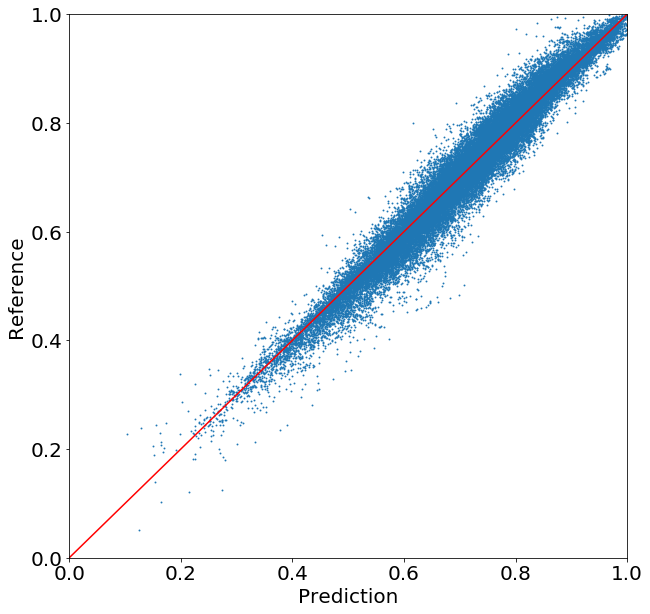

Training set: The coefficient of determination is: 0.958
Training set: The index of agreement is: 0.989
Training set: The root mean squared error is: 0.029


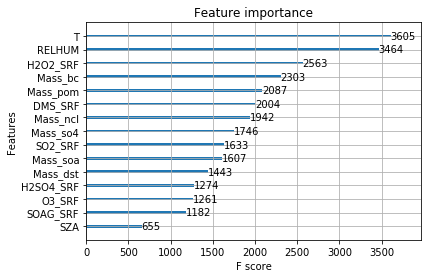

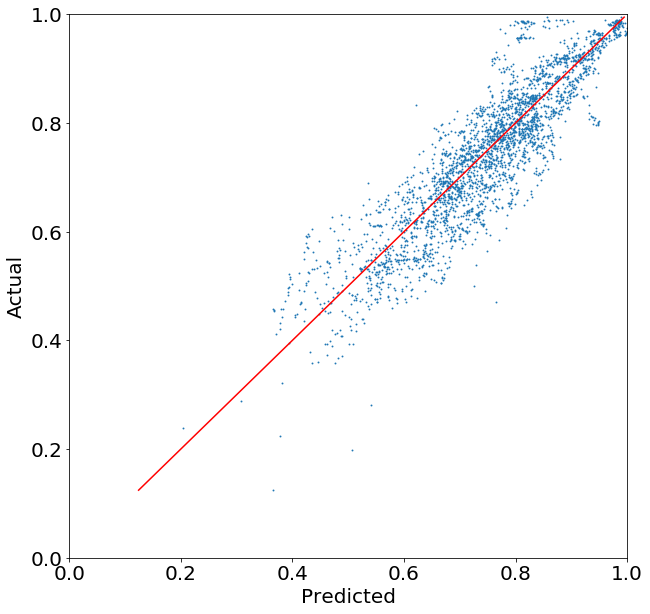

Testing set: The coefficient of determination is: 0.796
Testing set: The index of agreement is: 0.943
Testing set: The root mean squared error is: 0.062


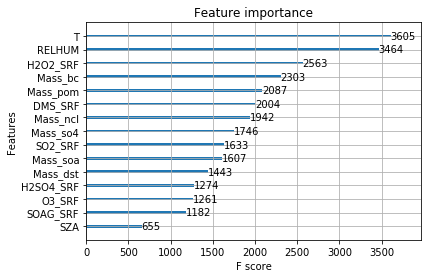

************************************
CPU times: user 4h 11min 46s, sys: 7min 10s, total: 4h 18min 56s
Wall time: 8min 25s


In [4]:
%%time
pred=ms[0]
print(pred)
ml_workflow_grid_search(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), 
                        features_ls=vari, pred=pred, 
                        para_dict=para_dict)

### chi_opt1

chi_opt1
Start grid search
Finish grid search, it takes 430.7839775085449
learning_rate 0.05
max_depth 5
n_estimators 1000


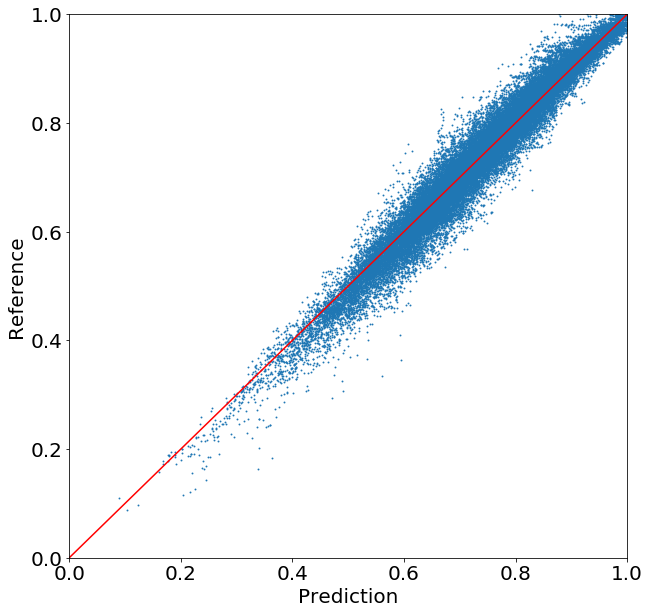

Training set: The coefficient of determination is: 0.958
Training set: The index of agreement is: 0.989
Training set: The root mean squared error is: 0.029


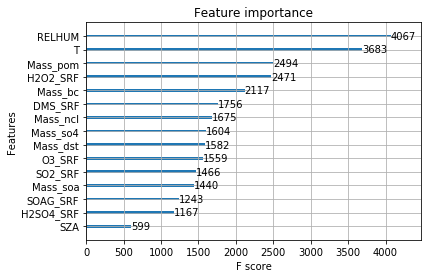

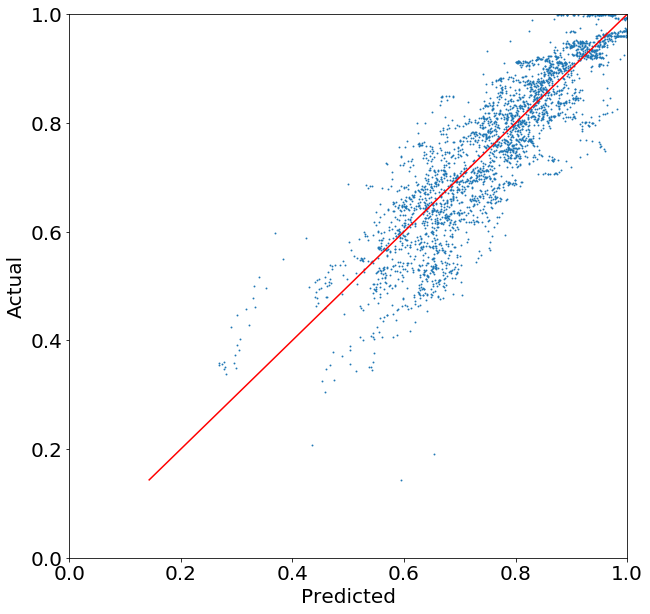

Testing set: The coefficient of determination is: 0.778
Testing set: The index of agreement is: 0.935
Testing set: The root mean squared error is: 0.069


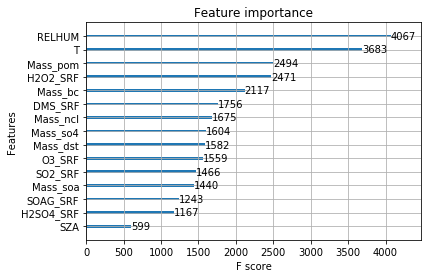

************************************
CPU times: user 4h 12min 38s, sys: 7min 12s, total: 4h 19min 51s
Wall time: 8min 27s


In [4]:
%%time
pred=ms[1]
print(pred)
ml_workflow_grid_search(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), 
                        features_ls=vari, pred=pred, 
                        para_dict=para_dict)

chi_opt2
Start grid search
Finish grid search, it takes 437.10445833206177
learning_rate 0.05
max_depth 6
n_estimators 1000


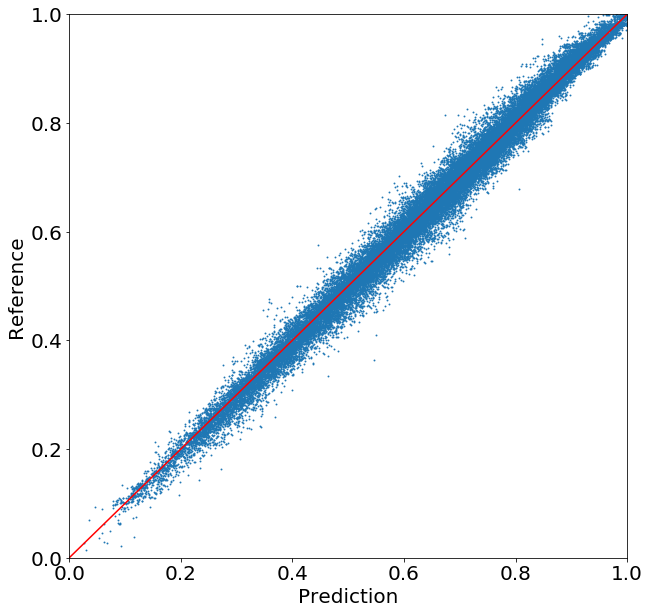

Training set: The coefficient of determination is: 0.988
Training set: The index of agreement is: 0.997
Training set: The root mean squared error is: 0.022


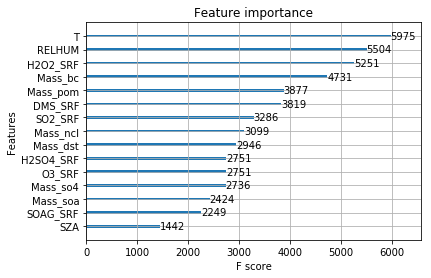

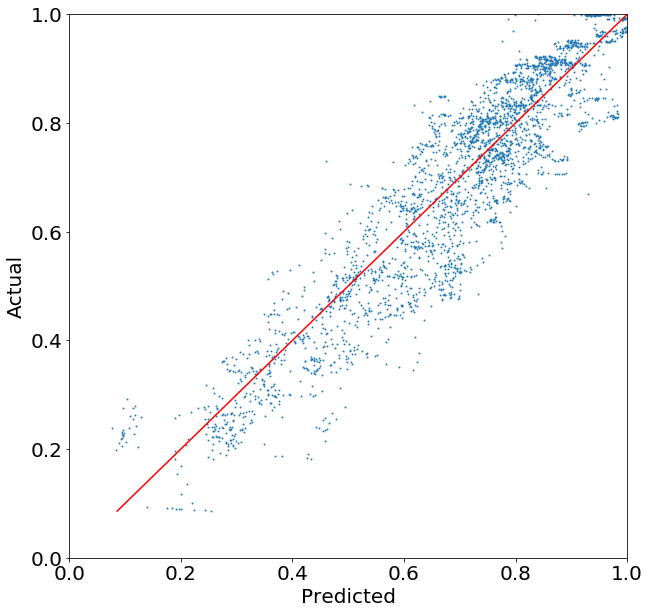

Testing set: The coefficient of determination is: 0.854
Testing set: The index of agreement is: 0.959
Testing set: The root mean squared error is: 0.080


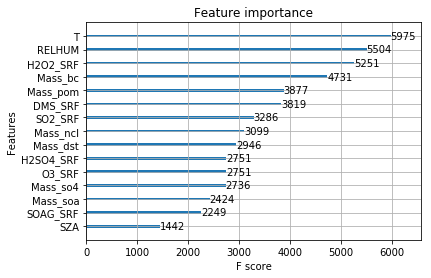

************************************
CPU times: user 4h 16min 28s, sys: 7min 28s, total: 4h 23min 56s
Wall time: 8min 52s


In [4]:
%%time
pred=ms[2]
print(pred)
ml_workflow_grid_search(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), 
                        features_ls=vari, pred=pred, 
                        para_dict=para_dict)

### chi_hyg

chi_hyg
Start grid search
Finish grid search, it takes 427.83972239494324
learning_rate 0.05
max_depth 5
n_estimators 1000


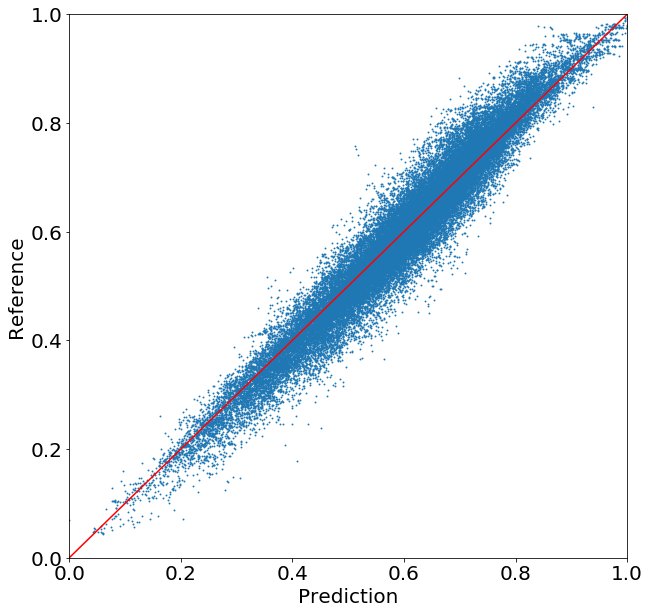

Training set: The coefficient of determination is: 0.941
Training set: The index of agreement is: 0.984
Training set: The root mean squared error is: 0.040


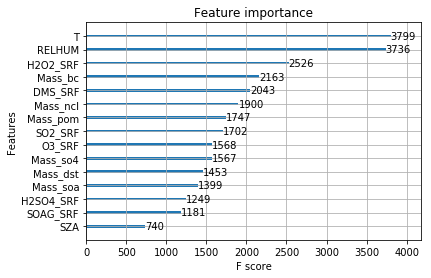

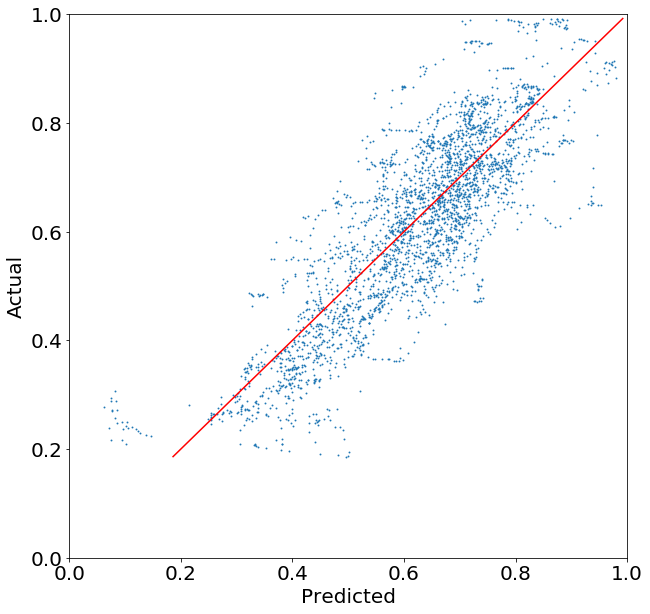

Testing set: The coefficient of determination is: 0.696
Testing set: The index of agreement is: 0.907
Testing set: The root mean squared error is: 0.094


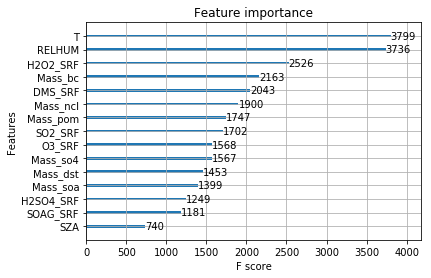

************************************
CPU times: user 4h 10min 55s, sys: 7min 8s, total: 4h 18min 4s
Wall time: 8min 23s


In [4]:
%%time
pred=ms[3]
print(pred)
ml_workflow_grid_search(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), 
                        features_ls=vari, pred=pred, 
                        para_dict=para_dict)

In [ ]:
#Train the model using the alternative hyperparameters

para_dict ={'learning_rate': 0.05,
                'max_depth': 6,
                'n_estimators': 1000}

for pred in ms:
    print(pred)
    ml_workflow(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), features_ls=vari, pred=pred, 
                            learning_rate=para_dict["learning_rate"],
                            max_depth=para_dict["max_depth"],
                            n_estimators=para_dict["n_estimators"])